# Aula de Visão Computacional: O Universo das Cores

**Professor:** Bem-vindos à nossa aula sobre **Modelos de Cor**!

Vocês já pararam para pensar que a forma como *nós* vemos as cores é drasticamente diferente de como a *máquina* as enxerga?
Para nós, cor é percepção, emoção, arte. Para o computador, cor é pura matemática, vetores e tensores.

Neste laboratório, vamos "hackear" essa visão computacional. Não vamos apenas aprender o que é RGB ou HSV, vamos entender **por que** precisamos de tantos modelos diferentes.

> **Intuição:** Imagine que você quer descrever uma cor para um artista. Você diria "Misture 20% de vermelho e 80% de verde" (RGB) ou diria "Eu quero um amarelo vibrante e brilhante" (HSV/HSL)?
> A máquina, nativamente, pensa como a mistura de tintas (RGB). Mas para analisarmos imagens (segmentar objetos, achar contornos), muitas vezes precisamos ensinar a máquina a pensar como o artista (HSV).

### Roteiro da Aula:
1.  **RGB vs BGR:** O mistério do "Azul que é Vermelho" no OpenCV.
2.  **HSV (Hue, Saturation, Value):** A ferramenta suprema para segmentação de cores.
3.  **Lab:** O espaço de cor que tenta imitar o olho humano.
4.  **Gamma Correction:** Por que suas imagens ficam escuras demais e como corrigir isso.



# 0) Setup e Utilitários
Vamos preparar nosso ambiente. Usaremos `matplotlib` para visualização e `openCV` para processamento.

**Importante:** O `matplotlib` espera imagens em **RGB**, mas o `OpenCV` carrega imagens em **BGR**. Criaremos helpers para lidar com isso.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage import data, img_as_float
from sklearn.cluster import KMeans

# Configuração de plot
plt.rcParams['figure.figsize'] = (10, 6)

# === HELPER FUNCTIONS ===

def show(img, title="", cmap=None):
    """Função helper para exibir imagens com Matplotlib."""
    plt.figure(figsize=(6,6))
    
    # Matplotlib espera RGB ou Grayscale. 
    # Se for grayscale (H, W), usamos cmap='gray'.
    if len(img.shape) == 2:
        plt.imshow(img, cmap='gray' if cmap is None else cmap)
    else:
        plt.imshow(img, cmap=cmap)
    
    plt.title(title)
    plt.axis("off")
    plt.show()

def to_rgb_from_bgr(bgr):
    """Converte imagem BGR (OpenCV) para RGB (Matplotlib)."""
    return cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

def to_bgr_from_rgb(rgb):
    """Converte imagem RGB para BGR."""
    return cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR)

print("Ambiente configurado com sucesso!")

Ambiente configurado com sucesso!


# 1) O Espaço RGB (Red, Green, Blue)

O modelo mais comum em hardware (monitores, câmeras). É um modelo **aditivo**:
- Começamos com Preto (0,0,0).
- Adicionamos luz Vermelha, Verde e Azul.
- Somar tudo dá Branco.

> [!NOTE]
> Uma imagem colorida é, matematicamente, um tensor de shape `(Altura, Largura, 3)`. Cada pixel é um vetor de 3 números.

Vamos carregar uma imagem de exemplo e examinar esses números.



Shape da imagem: (512, 512, 3)
Tipo de dado: uint8


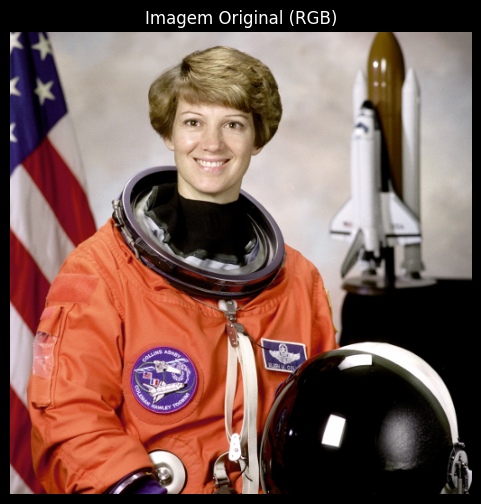

In [3]:
# Carregando imagem de exemplo do scikit-image
image = data.astronaut() # Esta imagem já vem em RGB no skimage

print(f"Shape da imagem: {image.shape}")
print(f"Tipo de dado: {image.dtype}")

show(image, "Imagem Original (RGB)")

### Visualizando os Canais Separadamente
Podemos separar os canais R, G e B. Note que ao visualizar um único canal, ele parece uma imagem em escala de cinza, onde **branco = alto valor dessa cor** e **preto = ausência dessa cor**.

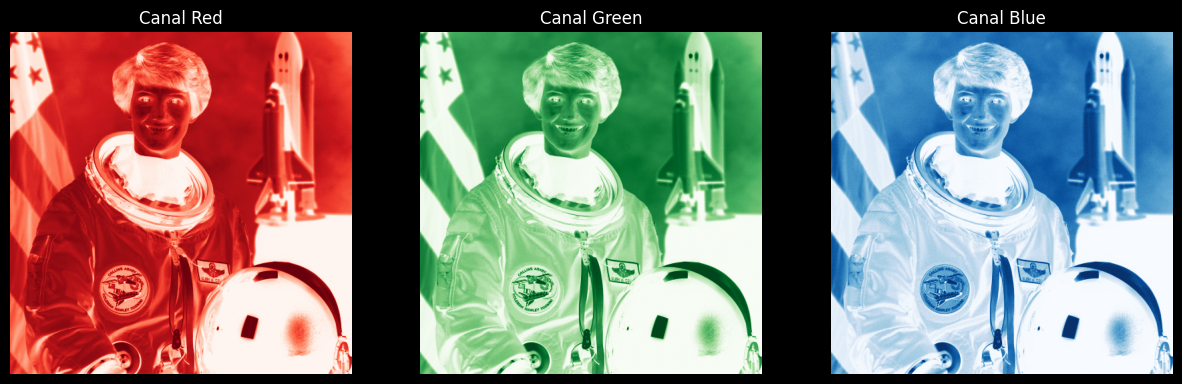

In [4]:
R = image[:, :, 0]
G = image[:, :, 1]
B = image[:, :, 2]

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(R, cmap='Reds'); ax[0].set_title("Canal Red")
ax[1].imshow(G, cmap='Greens'); ax[1].set_title("Canal Green")
ax[2].imshow(B, cmap='Blues'); ax[2].set_title("Canal Blue")

for a in ax: a.axis('off')
plt.show()

####  Mini-Exercício 1: Trocando Canais
Crie uma nova imagem onde o canal Vermelho e o Azul estão trocados. O que acontece com as cores?

# 2) A Armadilha do BGR (OpenCV)

**Professor:** Cuidado! Aqui mora uma das maiores pegadinhas da visão computacional.

Vocês notaram que no código anterior usamos `cv2.cvtColor`?
O OpenCV, por razões históricas (compatibilidade com hardware antigo de câmeras que entregavam os bytes BGR), carrega as imagens em **BGR** (Blue-Green-Red) e não RGB.

> [!WARNING]
> **A Pegadinha:** Se você carregar com OpenCV (`cv2.imread`) e exibir direto com Matplotlib (`plt.imshow`), sua imagem ficará com as cores trocadas (Vermelho vira Azul).



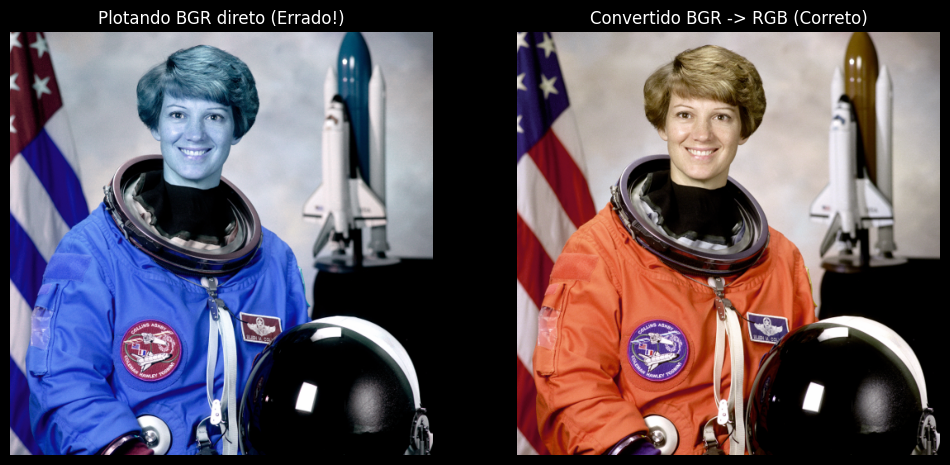

In [5]:
# Vamos simular o carregamento BGR convertendo nossa imagem RGB para BGR
image_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Errado: Plotar BGR como se fosse RGB
ax[0].imshow(image_bgr)
ax[0].set_title("Plotando BGR direto (Errado!)")
ax[0].axis('off')

# Certo: Converter antes de plotar
image_rgb_fixed = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
ax[1].imshow(image_rgb_fixed)
ax[1].set_title("Convertido BGR -> RGB (Correto)")
ax[1].axis('off')
plt.show()

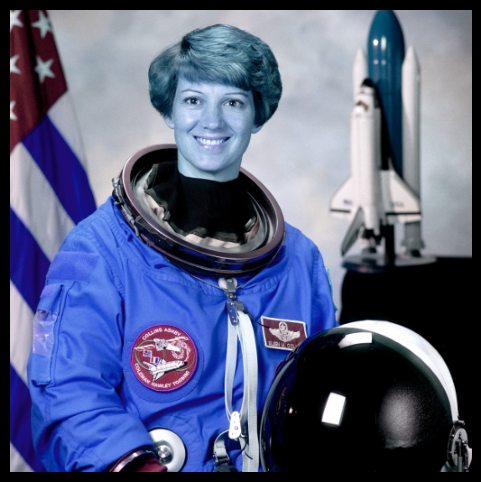

In [6]:
# Execício, trocar a cor verde pela azul.

img_trocada = image.copy()
img_trocada[:, :, 0], img_trocada[:, :, 2] = image[:, :, 2], image[:, :, 0]
show(img_trocada)

####  Mini-Exercício 2: O "filtro" Avatar
Carregue uma imagem sua (ou use a `data.astronaut` mesmo), converta para BGR e exiba. Note como a pele fica azulada.

# 3) Escala de Cinza (Grayscale)
Converter para preto e branco não é apenas tirar a média `(R+G+B)/3`.
O olho humano é muito mais sensível ao VERDE do que ao azul ou vermelho.

A fórmula de luminância correta (ITU-R BT.601) é aproximadamente:
$$ Gray = 0.299 \cdot R + 0.587 \cdot G + 0.114 \cdot B $$

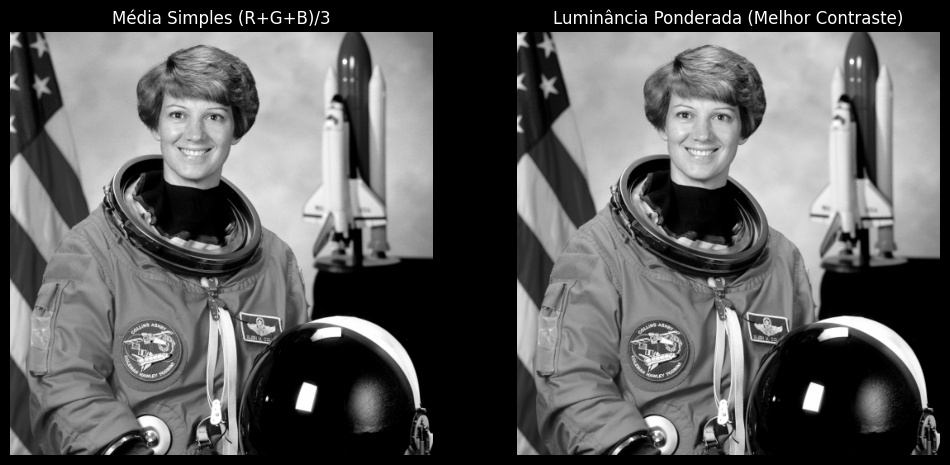

In [7]:
# Conversão Ingênua (Média)
gray_mean = image.mean(axis=2)

# Conversão Ponderada (Luminância) - OpenCV faz isso internamente
gray_weight = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(gray_mean, cmap='gray')
ax[0].set_title("Média Simples (R+G+B)/3")
ax[0].axis('off')

ax[1].imshow(gray_weight, cmap='gray')
ax[1].set_title("Luminância Ponderada (Melhor Contraste)")
ax[1].axis('off')
plt.show()

> **Insight:** Note como alguns detalhes podem ficar mais nítidos na versão ponderada. O canal verde carrega a maior parte da informação de "brilho" visual.

# 4) Espaço HSV (Hue, Saturation, Value)

**Professor:** RGB é ótimo para monitores, mas péssimo para algortimos de Visão.
Tente explicar a cor "Marrom Claro" em RGB. É difícil definir um *range* de R, G e B que pegue todos os tons de marrom.

No HSV (Hue, Saturation, Value), separamos a informação de:
1.  **Hue (Matiz):** Qual é a cor? (Vermelho, Amarelo, Azul...). É um ângulo no círculo cromático.
2.  **Saturation (Saturação):** Quão "pura" é a cor? (Cinza vs Neon).
3.  **Value (Valor/Brilho):** Quão clara é a cor? (Preto vs Cor Plena).

> [!TIP]
> **Dica de Ouro:** Para identificar objetos (como uma bola de tênis) independente da iluminação (sombra/sol), use HSV! O canal **H** (Matiz) se mantém quase constante mesmo se a luz mudar (mudando apenas **V**).



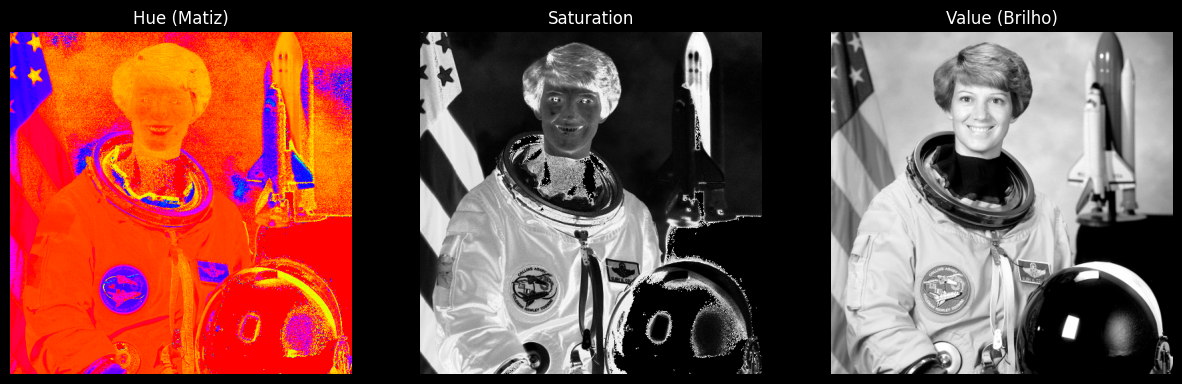

In [8]:
image_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

H, S, V = cv2.split(image_hsv)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(H, cmap='hsv'); ax[0].set_title("Hue (Matiz)")
ax[1].imshow(S, cmap='gray'); ax[1].set_title("Saturation")
ax[2].imshow(V, cmap='gray'); ax[2].set_title("Value (Brilho)")
for a in ax: a.axis('off')
plt.show()

### Exemplo Prático: Segmentando a cor Laranja (Traje do Astronauta)
No RGB seria difícil criar regras `if R > X and G < Y...`. No HSV, basta pegar um intervalo de Hue.

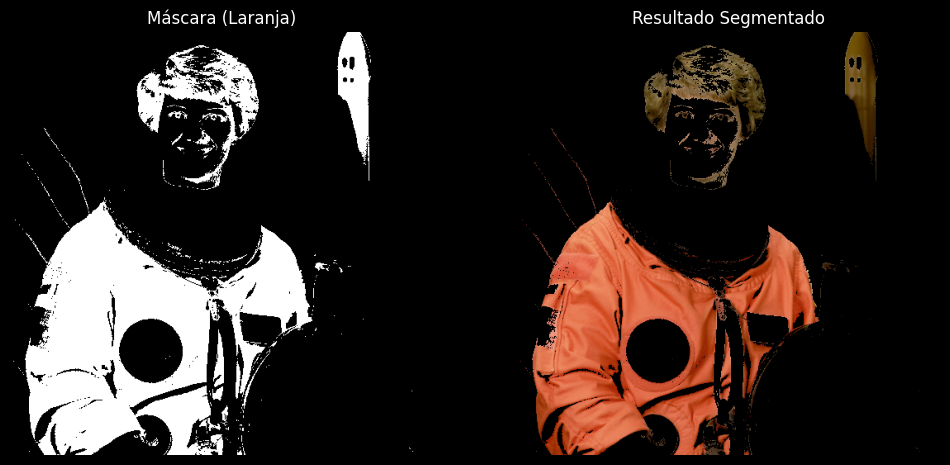

In [9]:
# Definindo intervalo para Laranja/Vermelho no OpenCV
# Hue do laranja é ~10-25 no OpenCV (escala 0-179)
lower_orange = np.array([5, 100, 50])  # H min, S min, V min
upper_orange = np.array([25, 255, 255]) # H max, S max, V max

mask = cv2.inRange(image_hsv, lower_orange, upper_orange)
result = cv2.bitwise_and(image, image, mask=mask)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(mask, cmap='gray')
ax[0].set_title("Máscara (Laranja)")
ax[1].imshow(result)
ax[1].set_title("Resultado Segmentado")
for a in ax: a.axis('off')
plt.show()

####  Mini-Exercício 3: Segmentando outra cor
Tente ajustar os valores de `lower` e `upper` para segmentar apenas a **bandeira azul** no fundo ou no braço do traje. (Dica: Azul tem Hue próximo de 110-130 no OpenCV).

# 5) Espaço LAB (CIELAB)

**Professor:** O Espaço LAB tenta ser **Perceptualmente Uniforme**.

Diferente do RGB, onde a "distância matemática" entre duas cores (Euclidiana) não reflete a distância que *nós* percebemos, o LAB foi desenhado para modelar a visão humana.
- **L:** Luminosidade (Claro/Escuro).
- **A:** Eixo Verde-Vermelho.
- **B:** Eixo Azul-Amarelo.

É muito usado em indústrias de tinta, têxtil e correções de cor profissionais.



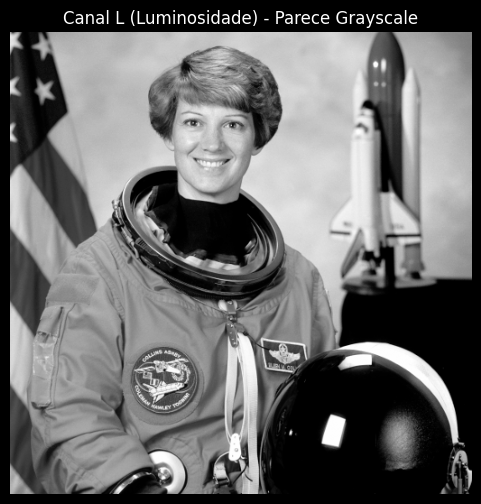

In [10]:
image_lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
L, A, B_channel = cv2.split(image_lab)

show(L, "Canal L (Luminosidade) - Parece Grayscale", cmap='gray')
# Os canais A e B são difíceis de interpretar visualmente sozinhos pois codificam oponência de cores

# 6) Quantização de Cores (K-Means)
E se quiséssemos representar a imagem usando apenas 4 cores (estilo "poster" ou 8-bit retro)?
Podemos usar Clustering (K-Means) no espaço RGB.

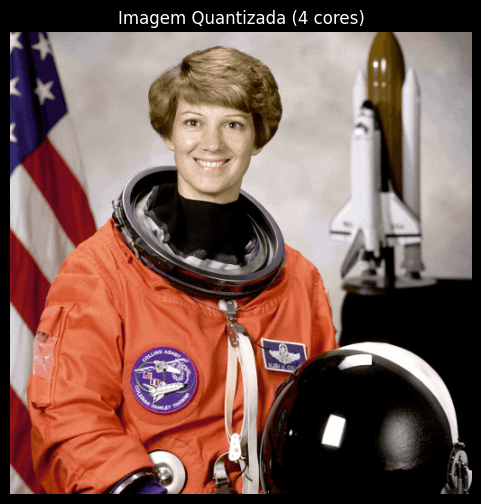

In [13]:
def quantize_image(img, k=4):
    # 1. Transformar imagem (H,W,3) em lista de pixels (H*W, 3)
    pixels = img.reshape((-1, 3))
    
    # 2. Aplicar K-Means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=4)
    kmeans.fit(pixels)
    
    # 3. Substituir cor de cada pixel pelo centróide do seu cluster
    centers = np.uint8(kmeans.cluster_centers_)
    labels = kmeans.labels_
    
    quantized = centers[labels].reshape(img.shape)
    return quantized

img_k4 = quantize_image(image, k=118)
show(img_k4, "Imagem Quantizada (4 cores)")

####  Mini-Exercício 4: K-Means manual
Teste com `k=2`, `k=16` e observe a diferença.

# 7) Tópico Avançado: Gamma Correction & Linearidade

**Professor:** Por que monitor e câmera não se entendem linearmente?

Nossos olhos são muito mais sensíveis a mudanças em tons escuros do que em tons claros (evolução para ver no escuro!). As câmeras e monitores aplicam uma curva **Gamma** para "comprimir" os dados e otimizar essa percepção.

> [!IMPORTANT]
> **Física vs Percepção:** A luz no mundo real é linear (1 lâmpada + 1 lâmpada = 2x luz). Mas a imagem JPEG que você tem já tem Gamma aplicado (não-linear).
> Se você fizer médias ou somas diretamente no RGB com Gamma, o resultado é **fisicamente incorreto** (embora visualmente aceitável muitas vezes).



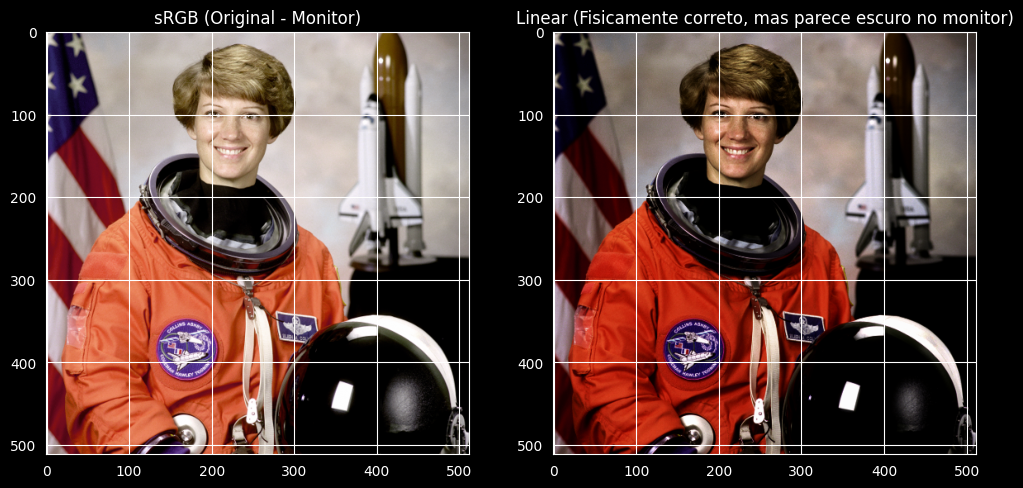

In [12]:
img_float = img_as_float(image)

# Remover gamma (aprox 2.2) -> Espaço Linear
img_linear = np.power(img_float, 2.2)

# Se exibirmos a imagem linear num monitor sRGB, ela vai parecer ESCURA
fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].imshow(img_float)
ax[0].set_title("sRGB (Original - Monitor)")

ax[1].imshow(np.clip(img_linear, 0, 1))
ax[1].set_title("Linear (Fisicamente correto, mas parece escuro no monitor)")
plt.show()

> **Dica de Mestre:** Se você redimensiona uma imagem (blur/resize), matematicamente deveria fazer isso no espaço **Linear**, e depois reaplicar o Gamma. Quase ninguém faz isso, mas é o correto para preservar brilho real.

# Conclusão
Dominamos os modelos de cor!
- Use **RGB** para visualização.
- Use **HSV** para segmentação e detecção de objetos por cor.
- Lembre sempre de converter `BGR` para `RGB` ao usar OpenCV + Matplotlib.
- Entenda que Grayscale é uma ponderação, não uma média simples.